In [1]:
import os
from PIL import Image, ImageDraw, ImageFont
import numpy as np
import pandas as pd
import random

data_path = "data" + os.sep
image_folders = [ data_path + "invasive_256x256" + os.sep + "output", data_path + "noninvasive_256x256" + os.sep + "output"]
dataset_name_invas = data_path + "dataset_invas.csv"
dataset_name_noninvas = data_path + "dataset_noninvas.csv"
dataset_name_test = data_path + "dataset_test.csv"
dataset_name_train = data_path + "dataset_train.csv"

image_bw = False

if not os.path.exists(dataset_name_test) and not os.path.exists(dataset_name_train):

    print("Converting data at " + data_path + "...")

    count = 0
    data_train = []
    data_test = []
    for folder in image_folders:
        data = []
        for file_name in os.listdir(folder):
            file_path = os.path.join(folder, file_name)
            # Check if it's an image file (common extensions)
            if os.path.isfile(file_path) and file_name.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
                if "noninvasive" in file_path:
                    row = [ file_path, 0]
                else:
                    row = [ file_path, 1]
                data.append(row)
                count += 1

        random.shuffle(data)
        chunk_size = int(len(data) * 0.8)
        data_train = data_train + data[0:chunk_size]
        data_test = data_test + data[chunk_size:]

    random.shuffle(data_train)
    random.shuffle(data_test)

    print("Preparing train...")
    data = []
    count = 0
    dot_cnt = 0
    for item in data_train:
        row = [ item[0], item[1] ]
        data.append(row)
        count += 1
        if count % 1000 == 0:
            print(".", end="")
            dot_cnt += 1
            if dot_cnt >= 20:
                print("")
                dot_cnt = 0

                print("Create dataframe...")
                df = pd.DataFrame(data)
                print("Write data set train...")
                if os.path.isfile(dataset_name_train):
                    df.to_csv(dataset_name_train, mode="a", index = False, header = False)
                else:
                    df.to_csv(dataset_name_train, index = False, header = True)
                del df
                data = []

    if len(data) > 0:
        print("")
        print("Create dataframe...")
        df = pd.DataFrame(data)
        print("Write data set train...")
        if os.path.isfile(dataset_name_train):
            df.to_csv(dataset_name_train, mode="a", index = False, header = False)
        else:
            df.to_csv(dataset_name_train, index = False, header = True)
        del df

    print("")
    print("Preparing test...")
    data = []
    dot_cnt = 0
    for item in data_test:
        row = [ item[0], item[1] ]
        data.append(row)
        count += 1
        if count % 1000 == 0:
            print(".", end="")
            dot_cnt += 1
            if dot_cnt >= 20:
                print("")
                dot_cnt = 0

                print("Write data set test...")
                df = pd.DataFrame(data)
                if os.path.isfile(dataset_name_test):
                    df.to_csv(dataset_name_test, mode="a", index = False, header = False)
                else:
                    df.to_csv(dataset_name_test, index = False, header = True)
                del df
                data = []

    if len(data) > 0:
        print("")
        print("Write data set test...")
        df = pd.DataFrame(data)
        if os.path.isfile(dataset_name_test):
            df.to_csv(dataset_name_test, mode="a", index = False, header = False)
        else:
            df.to_csv(dataset_name_test, index = False, header = True)
        del df

    print("Total data set: " + str(count))

else:

    print("Using data from " + dataset_name_train)
    print("Using data from " + dataset_name_test)    

Using data from data\dataset_train.csv
Using data from data\dataset_test.csv


In [2]:
from torch.utils.data import DataLoader
from torchvision.transforms.functional import pil_to_tensor

class CustomImageDataset(DataLoader):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        label = self.img_labels.iloc[idx, 1]
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        img = Image.open(img_path)
        width, height = img.size
        if width != 256 or height != 256:
            img = img.resize((256, 256))
        if image_bw:
            img = img.convert("L")
        image = np.array(img).flatten()
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

# Load training data
print("Loading train data from " + dataset_name_train)
batch_size = 64
training_data = CustomImageDataset(dataset_name_train, "", None)
train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle = False)

print("Loading test data from " + dataset_name_test)
testing_data = CustomImageDataset(dataset_name_test, "", None)
testing_dataloader = DataLoader(testing_data, batch_size=batch_size, shuffle = False)


Loading train data from data\dataset_train.csv
Loading test data from data\dataset_test.csv


In [3]:
import xgboost as XGB
from datetime import datetime
import torch
from sklearn.preprocessing import Normalizer

alg = "XGB"
print("Training with " + alg + "...")

# Initialize XGBoost classifier
if torch.cuda.is_available():
    # clf = XGB.XGBClassifier(device="cuda", n_estimators=batch_size, random_state=42)
    clf = XGB.XGBClassifier(device="cuda", n_estimators=batch_size)
    print("Enable Cuda")
else:
    # clf = XGB.XGBClassifier(n_estimators=batch_size, random_state=42)
    clf = XGB.XGBClassifier(n_estimators=batch_size)

max_train = 0

normalizer = Normalizer(norm='l2')

count = 0
print(str(count).rjust(10), end="")
ts = datetime.now()
first = True
print_stride = 1000
next_print = print_stride
dot_cnt = 0
for i, (images, labels) in enumerate(train_dataloader):
    count += len(labels)

    images_normalized = normalizer.fit_transform(images)
    if first:
        clf.fit(images_normalized, labels)
        first = False
    else:
        clf.fit(images_normalized, labels, xgb_model=clf.get_booster())
    if count >= next_print:
        next_print += print_stride
        print(".", end="")
        dot_cnt += 1
        if dot_cnt >= 20:
            dot_cnt = 0
            elapsed = datetime.now() - ts
            print(f"{elapsed}")
            print(str(count).rjust(10), end="")

    if max_train > 0 and count >= max_train:
        break

delta = datetime.now() - ts
print("")
print("Time: " + str(delta.seconds) + "." + str(delta.microseconds) + " seconds", flush=True)
print("Model trained with " + str(count))

Training with XGB...
Enable Cuda
         0....................0:08:41.210653
     20032....................0:20:19.837926
     40000....................0:35:23.243056
     60032....................0:53:46.678478
     80000....................1:16:26.127806
    100032....................1:43:00.256761
    120000....................2:13:23.405566
    140032....................2:47:31.866834
    160000
Time: 10051.866834 seconds
Model trained with 160000


In [ ]:
import pandas as pd

df = pd.DataFrame(clf.feature_importances_)
df.to_csv("xgb-importance.csv")

In [ ]:
import pandas as pd

data_csv = pd.read_csv("xgb-importance.csv")
# data_csv = data_csv.head(2000)
print(data_csv)

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

w = 256
h = 256
data_rgb = [[0 for x in range(w)] for y in range(h)]

for index, row in data_csv.iterrows():
    idx = int(row[0])
    val = row[1]
    col = (idx % (256 * 3)) // 3
    row = idx // (256 * 3)
    if val > data_rgb[row][col]:
        data_rgb[row][col] = val

df_rgb = pd.DataFrame(data_rgb)
print(df_rgb)

tickloop = range(0, 255, 16)
ticks = []
ticklabels = []
for label in tickloop:
    ticks.append(label)
    ticklabels.append(str(label))

plt.figure(figsize=(20, 20), dpi=72)  # width = 8 inches, height = 6 inches
hm = sns.heatmap(df_rgb, annot=False, cmap="Reds")
hm.set_xticks(ticks)
hm.set_xticklabels(ticklabels) 
hm.set_yticks(ticks)
hm.set_yticklabels(ticklabels) 
plt.title('XGB Heat Map')
plt.xlabel('X-Pixel')
plt.ylabel('Y-Pixel')
plt.show()

In [ ]:
# clf.save_model('asdrip-xgb-model.json')

In [ ]:
# from datetime import datetime
# import xgboost as XGB
# alg = "XGB"
# print_stride = 1000
# batch_size = 64
# clf = XGB.XGBClassifier(device="cuda", n_estimators=batch_size, random_state=42)
# clf.load_model('asdrip-xgb-model.json')

In [4]:

correct = 0
total = 0
targets = []
preds = []

max_test = 0

print("Testing with " + alg + "...")

print(str(total).rjust(10), end="")
ts = datetime.now()
first = True
next_print = print_stride
dot_cnt = 0
for i, (images, labels) in enumerate(testing_dataloader):
    total += len(labels)
    targets = targets + labels[:].tolist()

    images_normalized = normalizer.transform(images)
    pred = clf.predict(images_normalized)
    correct += (pred == labels).sum().item()
    preds = preds + pred[:].tolist()

    if total >= next_print:
        next_print += print_stride
        print(".", end="")
        dot_cnt += 1
        if dot_cnt >= 20:
            dot_cnt = 0
            elapsed = datetime.now() - ts
            print(f"{elapsed}")
            print(str(total).rjust(10), end="")
    
    if max_test > 0 and total >= max_test:
        break

delta = datetime.now() - ts
print("")
print("Time: " + str(delta.seconds) + "." + str(delta.microseconds) + " seconds", flush=True)
print("Model test with " + str(total))

print('Accuracy of the mode: {} %'.format(100 * correct / total))


Testing with XGB...
         0

C:\Users\Chloe\AppData\Roaming\Python\Python312\site-packages\xgboost\core.py:729: UserWarning: [23:48:07] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


....................0:09:37.438067
     20032....................0:19:20.481325
     40000
Time: 1160.481325 seconds
Model test with 40000
Accuracy of the mode: 90.8025 %


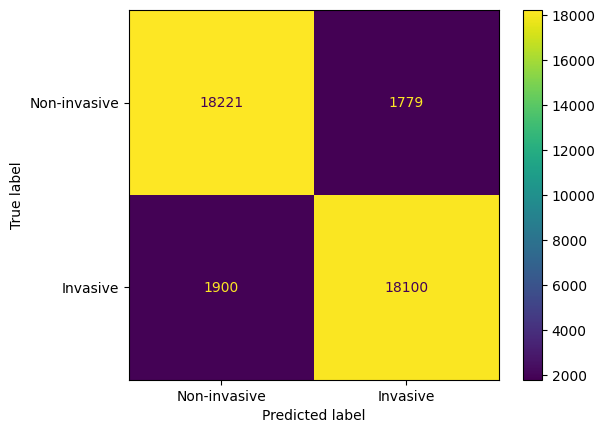

Accuracy: 0.908025 
F1 score: 0.907745931442614
Recall: 0.905
Precision: 0.9105085768901856


In [5]:
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics

actual = targets
predicted = preds

confusion_matrix = metrics.confusion_matrix(actual, predicted)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ["Non-invasive", "Invasive"])

cm_display.plot()
plt.show()

print('Accuracy: {} '.format(metrics.accuracy_score(actual, predicted)))
print('F1 score: {}'.format(metrics.f1_score(actual, predicted)))
print('Recall: {}'.format(metrics.recall_score(actual, predicted)))
print('Precision: {}'.format(metrics.precision_score(actual, predicted)))

```
Result of 200K data set:

Training with XGB...
Enable Cuda
         0.....................0:12:17.752763
     21056.....................0:32:02.787330
     42048.....................0:59:34.594179
     63040.....................1:32:23.624490
     84032.....................2:12:20.311267
    105024.....................3:00:21.447866
    126016.....................3:56:58.407031
    147008.............
Time: 16590.227721 seconds
Model trained with 160000

Testing with XGB...
         0....................0:09:08.187985
     20032....................0:18:11.448557
     40000

Time: 1091.449559 seconds
Model test with 40000
Accuracy of the mode: 91.4375 %

Accuracy: 0.914375 
F1 score: 0.9133503681028158
Recall: 0.90255
Precision: 0.924412352127823
```

````

Run 1:
Accuracy: 0.91025 
F1 score: 0.9129443716960085
Recall: 0.9412
Precision: 0.8863358131650815

Run 2:
Accuracy: 0.91025 
F1 score: 0.9129443716960085
Recall: 0.9412
Precision: 0.8863358131650815

Run 3:
Accuracy: 0.91025 
F1 score: 0.9129443716960085
Recall: 0.9412
Precision: 0.8863358131650815


````

````
Re-run with L2 normalized on 8/15/2025

Training with SGDC...
         0.....................0:00:37.261919
     21056.....................0:01:13.746557
     42048.....................0:01:50.174283
     63040.....................0:02:27.119370
     84032.....................0:03:04.247695
    105024.....................0:03:41.061003
    126016.....................0:04:18.199520
    147008.............
Time: 281.247476 seconds
Model trained with 160000

Testing with SGDC...
         0....................0:00:50.436376
     20032....................0:01:40.508347
     40000
Time: 100.508347 seconds
Model test with 40000
Accuracy of the mode: 95.2825 %

````

````
Re-run with normalize 8/15/2025

Training with XGB...
Enable Cuda
         0....................0:08:41.210653
     20032....................0:20:19.837926
     40000....................0:35:23.243056
     60032....................0:53:46.678478
     80000....................1:16:26.127806
    100032....................1:43:00.256761
    120000....................2:13:23.405566
    140032....................2:47:31.866834
    160000
Time: 10051.866834 seconds
Model trained with 160000

Testing with XGB...
         0
C:\Users\Chloe\AppData\Roaming\Python\Python312\site-packages\xgboost\core.py:729: UserWarning: [23:48:07] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)
....................0:09:37.438067
     20032....................0:19:20.481325
     40000
Time: 1160.481325 seconds
Model test with 40000
Accuracy of the mode: 90.8025 %
```